In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression

def arctic_average(xarray, data_string):
    """
    Find monthly averages timeseries.
    """
    if data_string == 'TAS':
        arctic_xarray = xarray.sel(latitude=slice(70,90))
        arctic_xarray = arctic_xarray.sel(time=slice('1958', '2015'))
        data_array = arctic_xarray.tas_mean.values
    elif data_string == 'SIC':
        arctic_xarray = xarray.sel(latitude=slice(90,70))
        arctic_xarray = arctic_xarray.sel(time=slice('1958', '2015'))
        data_array = arctic_xarray.seaice_conc.values
    weights = np.cos(np.deg2rad(arctic_xarray.latitude.values))
    weights_map = np.broadcast_to(weights, (arctic_xarray.sizes['longitude'],arctic_xarray.sizes['latitude'])).T
    weighted_data_array = np.multiply(data_array, weights_map[np.newaxis, :])
    weight_maps_nanned = [np.multiply(np.abs(np.isnan(weighted_data_array[i])*1-1), weights_map) for i in range(0, len(weighted_data_array))]
    weights_reshaped = np.reshape(weight_maps_nanned,  (len(weight_maps_nanned), np.shape(weight_maps_nanned)[1]*np.shape(weight_maps_nanned)[2]))
    denom = np.nansum(weights_reshaped, axis=1)
    shape = np.shape(weighted_data_array)
    weighted_data_reshaped = np.reshape(weighted_data_array, (shape[0], shape[1]*shape[2]))
    weighted_sum = np.nansum(weighted_data_reshaped, axis=1)
    weighted_average = np.divide(weighted_sum, denom)
    return(weighted_average)

def djf_ts_mean(timeseries):
    """
    This function finds the mean over DJF data. Importantly, this averages over the winter time from
    1 full wintertime season (spanning two years).
    """
    ts_cal = np.reshape(timeseries, (int(len(timeseries)/12), 12))
    ts_jfd_cal = np.transpose([ts_cal[:,0], ts_cal[:,1], ts_cal[:,11]])
    ts_jfd_ts_195859_201415 = ts_jfd_cal.ravel()[2:-1]
    ts_jdf_cal_organized = np.reshape(ts_jfd_ts_195859_201415, (int(len(ts_jfd_ts_195859_201415)/3), 3))
    ts_jdf_mean = np.nanmean(ts_jdf_cal_organized, axis=1)
    return(ts_jdf_mean)

def djf_slp_mean(slp):
    """
    This function finds the mean over DJF data just for slp.
    """
    slp_data = slp.prmsl.values
    slp_data_cal = np.reshape(slp_data, (int(len(slp_data)/12), 12, 71,360))
    slp_data_cal = slp_data_cal - np.nanmean(slp_data_cal, axis=0)
    slp_jfd_cal = np.swapaxes([slp_data_cal[:,0], slp_data_cal[:,1], slp_data_cal[:,11]], 0,1)
    slp_jfd_ts = np.reshape(slp_jfd_cal, (58*3, 71,360))[2:-1]
    slp_jfd_cal_organized = np.reshape(slp_jfd_ts, (int(len(slp_jfd_ts)/3), 3, 71,360))
    slp_jdf_mean = np.nanmean(slp_jfd_cal_organized, axis=1)
    return(slp_jdf_mean)

def CC_map(slp_map, timeseries):
    """
    This function creates a one-pt correlation coefficient map between slp and a given timeseries.
    """
    CC = []
    for lat in range(np.shape(slp_map)[1]):
        lat_line = []
        for lon in range(np.shape(slp_map)[2]):
            slp_ts = slp_map[:,lat,lon]
            correlation = stats.pearsonr(slp_ts, timeseries)[0]
            lat_line.append(correlation)
        CC.append(lat_line)
    return(CC)

# load data
HadCrut = xr.open_dataset('/home/disk/pna2/aodhan/ArcticAttribution/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc')
SIC = xr.open_dataset('/home/disk/pna2/aodhan/ArcticAttribution/GriddedMonthlySeaIceExtentAndConcentration.nc')
SLP = xr.open_dataset('/home/disk/pna2/aodhan/ArcticAttribution/SLP_NOAA_20thCenturyReanalysisEnsembleMonthlyMean.nc')
CO2 = pd.read_csv('/home/disk/pna2/aodhan/ArcticAttribution/MaunaLoaCO2_Monthly_noReadMe.csv', on_bad_lines='skip')

# get arctic timeseries over correct time period
actic_tas = arctic_average(xarray=HadCrut, data_string='TAS')
actic_sic = arctic_average(xarray=SIC, data_string='SIC')

# get slp data N of 20 degrees and over correct time period
slp_N20 = SLP.sel(lat=slice(20,90))
slp = slp_N20.sel(time=slice('1958', '2015'))
slp_weights = np.cos(np.deg2rad(slp.lat.values))

# get CO2 monthly timeseries
co2_MaunaLoa = CO2[(CO2.year >= 1958) & (CO2.year <= 2015)].average.values

# get djf mean for data
tas_djf = djf_ts_mean(actic_tas)
tas_djf = tas_djf - np.nanmean(tas_djf)
sic_djf = djf_ts_mean(actic_sic)
sic_djf = sic_djf - np.nanmean(sic_djf)
slp_djf = djf_slp_mean(slp)
slp_djf = slp_djf - np.nanmean(slp_djf, axis=0)
co2_djf = djf_ts_mean(co2_MaunaLoa)
co2_djf = np.log(co2_djf/278) # this finds natural log of ratio for CO2 vs preindustrial levels
co2_djf = co2_djf - np.nanmean(co2_djf)

# standardize data
tas_djf_std = tas_djf/np.nanstd(tas_djf)
sic_djf_std = sic_djf/np.nanstd(sic_djf)
slp_djf_std = slp_djf/np.nanstd(slp_djf, axis=0)
co2_djf_std = co2_djf/np.nanstd(co2_djf)

In [2]:
def dynamic_adjustment(X, Y, weights, pls_number):
    # find timeperiod
    decades = np.arange(195.8, 201.5, 0.1)
    
    # detrend Y
    Y_regression = stats.linregress(x=decades, y=Y)
    Y_regression = Y_regression[1] + Y_regression[0]*decades
    Y_detrended = Y - Y_regression
    
    # detrend X
    X_detrended = []
    for lat in range(np.shape(X)[1]):
        lat_line = []
        for lon in range(np.shape(X)[2]):
            X_ts = X[:,lat,lon]
            X_regression = stats.linregress(x=decades, y=X_ts)
            X_regression = X_regression[1] + X_regression[0]*decades
            X_detrended_ts = X_ts - X_regression
            lat_line.append(X_detrended_ts)
        X_detrended.append(lat_line)
    X_detrended = np.swapaxes(X_detrended, 0,2)
    X_detrended = np.swapaxes(X_detrended, 1,2)  
    
    # find correlation-coefficient map (CC)
    CC = CC_map(X_detrended, Y_detrended)

    # weight CC by area and normalize
    CC_weighted = np.multiply(CC, weights[:,np.newaxis])
    CC_weighted_1d = CC_weighted.ravel()
    CC_normed = CC_weighted_1d/np.sqrt(np.dot(CC_weighted_1d, CC_weighted_1d))
    CC_weighted_normed = np.reshape(CC_normed, np.shape(CC_weighted))

    # project X onto weighted CC
    Z = np.array([np.dot(CC_weighted_normed.ravel(), X[i].ravel()) for i in range(0, len(X))])
    Z_normed =  Z/np.sqrt(np.dot(Z, Z))
    X_sample_x_structure = np.reshape(X, (len(X), np.shape(X)[1]*np.shape(X)[2]))
    P = np.matmul(X_sample_x_structure.T, Z_normed)

    # regress Z out of Y
    beta = np.matmul(Z_normed.T, Y)
    Y_regressed_out_Z = Y - beta*Z_normed # should this Z be normed?

    # regress Z out of X
    X_regressed_out_Z = X_sample_x_structure - np.matmul(Z_normed.reshape(-1,1), P.T.reshape(1,-1))
    X_regressed_out_Z = X_regressed_out_Z.reshape(np.shape(X))
    
    return(X_regressed_out_Z, Y_regressed_out_Z, Z_normed)

# Step one: Dynamically adjust TAS 
X = slp_djf_std.copy()
Y = tas_djf_std.copy()
Zs_tas = []
for k in range(3):
    X, Y, Z = dynamic_adjustment(X, Y, weights=slp_weights, pls_number=k)
    Zs_tas.append(Z)
# now that you have the components of the dynamic adjustment, regress them onto TAS
tas_reg = LinearRegression().fit(np.transpose(Zs_tas), tas_djf)
tas_dynamically_induced = tas_reg.predict(np.transpose(Zs_tas))
# adjust the TAS timeseries by removing the dynamically induced component
tas_dynamically_adjusted = tas_djf - tas_dynamically_induced 
decades = np.arange(195.8, 201.5, 0.1)

# Step two: Dynamically adjust SIC
X = slp_djf_std.copy()
Y = sic_djf_std.copy()
Zs_sic = []
for k in range(3):
    X, Y, Z = dynamic_adjustment(X, Y, weights=slp_weights, pls_number=k)
    Zs_sic.append(Z)
sic_reg = LinearRegression().fit(np.transpose(Zs_sic), sic_djf)
sic_dynamically_induced = sic_reg.predict(np.transpose(Zs_sic))
sic_dynamically_adjusted = sic_djf - sic_dynamically_induced
# regress dynamically adjusted SIC onto dynamically adjusted TAS
tas_reg_sic = LinearRegression().fit(sic_dynamically_adjusted.reshape(-1, 1), tas_dynamically_adjusted)
tas_sic_induced = tas_reg_sic.predict(sic_dynamically_adjusted.reshape(-1, 1))
tas_dynamic_and_sic_adjusted = tas_dynamically_adjusted - tas_sic_induced

# Step three: regress residual TAS onto ln(CO2/278) 
tas_reg_co2 = LinearRegression().fit(co2_djf.reshape(-1, 1), tas_dynamic_and_sic_adjusted)
tas_co2_induced = tas_reg_co2.predict(co2_djf.reshape(-1, 1))

# Step four: sum components
Regression_sum = tas_dynamically_induced + tas_sic_induced + tas_co2_induced

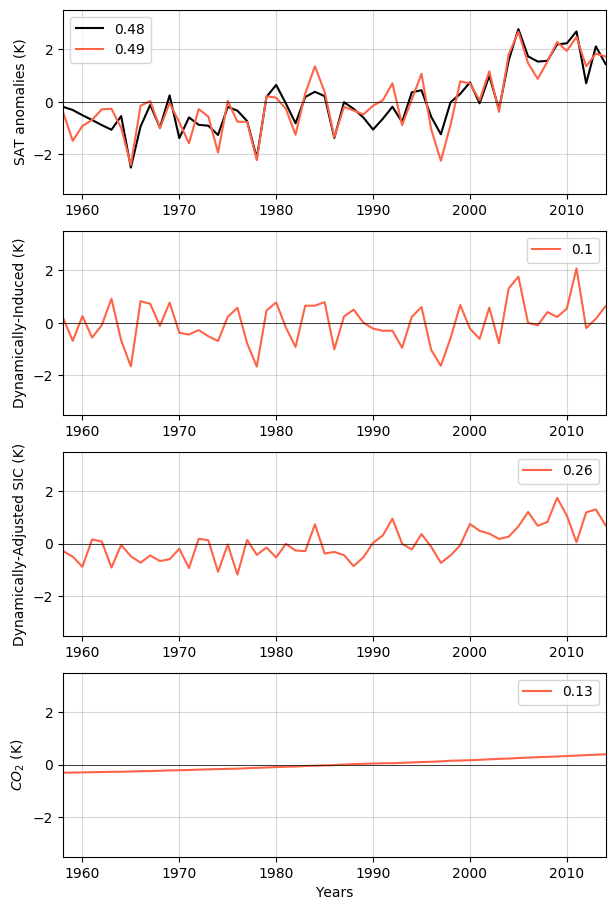

In [4]:
from sklearn.linear_model import LinearRegression

decades = np.arange(195.8, 201.5, 0.1)
fig, axs = plt.subplots(4,1, figsize=(7,11))
################################################################
tas_djf_trend = stats.linregress(x=decades, y=tas_djf)[0]
tas_reg_trend = stats.linregress(x=decades, y=Regression_sum)[0]
axs[0].plot(decades*10, tas_djf, color='black', label=np.around(tas_djf_trend, 2))
axs[0].plot(decades*10, Regression_sum, color='tomato', label=np.around(tas_reg_trend, 2))
axs[0].set_ylabel('SAT anomalies (K)')
################################################################
dynamical_trend = stats.linregress(x=decades, y=tas_dynamically_induced)[0]
axs[1].plot(decades*10, tas_dynamically_induced, color='tomato', label=np.around(dynamical_trend, 2))
axs[1].set_ylabel('Dynamically-Induced (K)')
################################################################
tas_sic_trend = stats.linregress(x=decades, y=tas_sic_induced)[0]
axs[2].plot(decades*10, tas_sic_induced, color='tomato', label=np.around(tas_sic_trend, 2))
axs[2].set_ylabel('Dynamically-Adjusted SIC (K)')
################################################################
tas_co2_trend = stats.linregress(x=decades, y=tas_co2_induced)[0]
axs[3].plot(decades*10, tas_co2_induced, color='tomato', label=np.around(tas_co2_trend, 2))
axs[3].set_ylabel('$CO_{2}$ (K)')
axs[3].set_xlabel('Years')
for x in range(4):
    axs[x].plot(decades*10, np.zeros(len(tas_djf)), color='black', linewidth=0.5)
    axs[x].set_ylim(-3.5,3.5)
    axs[x].set_xlim(1958,2014)
    axs[x].legend()
    axs[x].grid(alpha=0.5)

In [32]:
def regression_maps(slp_djf_std, z_ts):
    # detrend SLP
    slp_detrended = []
    for lat in range(np.shape(slp_djf_std)[1]):
        lat_line = []
        for lon in range(np.shape(slp_djf_std)[2]):
            slp_djf_std_ts = slp_djf_std[:,lat,lon]
            slp_djf_std_regression = stats.linregress(x=decades, y=slp_djf_std_ts)
            X_regression = slp_djf_std_regression[1] + slp_djf_std_regression[0]*decades
            X_detrended_ts = slp_djf_std_ts - X_regression
            Z_slp_regression = stats.linregress(x=z_ts, y=X_detrended_ts)[0]
            lat_line.append(Z_slp_regression)
        slp_detrended.append(lat_line)
    return(slp_detrended)

# find correlation maps of detrended SLP with PLS regression components
regression_maps_with_Zs = []
for z in Zs_tas:
    regression_map_NH = regression_maps(slp_djf, z)
    regression_maps_with_Zs.append(regression_map_NH)
regression_maps_with_Zs = np.array(regression_maps_with_Zs)

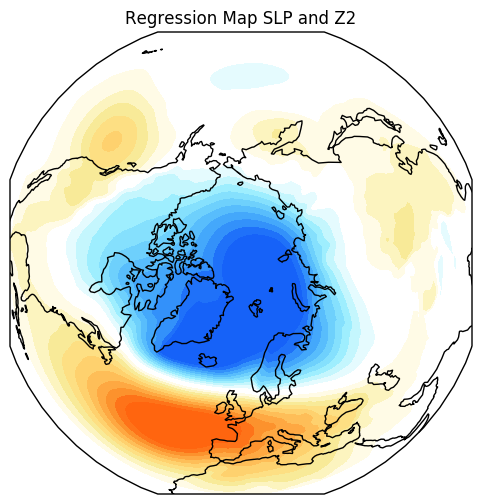

In [110]:
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from matplotlib.colors import LinearSegmentedColormap

# Create Custom Color Map
colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)

#Plotting is below
lat_bins = np.linspace(20, 90., 71)
lon_bins = np.linspace(0, 360, 360)

lim = np.linspace(-2000, 2000, 21)
subplot_kw = dict(projection=ccrs.Orthographic(central_longitude=0, central_latitude=90))
fig, ax = plt.subplots(1, 1, figsize=(7, 6), subplot_kw=subplot_kw)
####################################################################################
ax.coastlines()
#ax.set_extent([ -20.0, 90.0])
ax.set_title('Regression Map SLP and Z2')
map_cyclic, lon = add_cyclic_point(regression_maps_with_Zs[1], coord=lon_bins)
im = ax.contourf(lon, lat_bins, map_cyclic, 20, levels=lim,
                 transform=ccrs.PlateCarree(), extend='both', cmap=custom_cmap)

In [85]:
# find AO index
AO = pd.read_csv('/home/disk/p/aodhan/ArcticAttribution/AO_ascii.csv', sep='   ', header=None, names=['Year', 'Month', 'AO'])
AO_1958_2015 = AO[(AO['Year'] >= 1958) & (AO['Year'] <= 2015)]
AO_ts = AO_1958_2015.AO.values
AO_djf = djf_ts_mean(AO_ts)

# find NPI 
NP = pd.read_csv('/home/disk/p/aodhan/ArcticAttribution/NPI_ascii.csv', sep='  ', header=None, names=['Time',  'NP'])
NP_1958_2015 = NP[(NP['Time'] >= 195801) & (NP['Time'] <= 201512)]
NP_ts = NP_1958_2015.NP.values
NP_djf = djf_ts_mean(NP_ts)

# find ONI
ONI = pd.read_csv('/home/disk/p/aodhan/ArcticAttribution/ONI_ascii.csv', sep='  ', header=None, names=['Year',  '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
ONI_1958_2015 = ONI[(ONI['Year'] >= 1958) & (ONI['Year'] <= 2015)]
ONI_array = ONI_1958_2015.values
ONI_ts = ONI_array[:,1:].astype(float).ravel()
ONI_djf = djf_ts_mean(ONI_ts)

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


(57, 6)
(6, 6, 2)


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


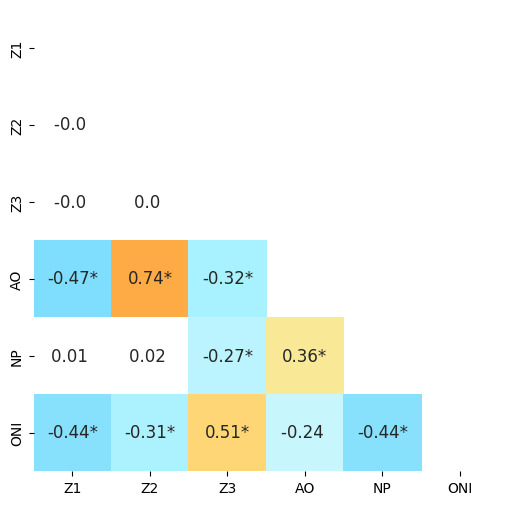

In [103]:
import seaborn as sns
def correlation_matrix_creator(predictors_and_target):
    predictors_and_target = predictors_and_target.to_numpy()
    corr_matrx = []
    for ts_1 in range(len(predictors_and_target.T)):
        corr_row = []
        for ts_2 in range(len(predictors_and_target.T)):
            timeseries_1 = predictors_and_target[:,ts_1]
            timeseries_2 = predictors_and_target[:,ts_2]
            N = len(timeseries_1)
            r = stats.pearsonr(timeseries_1[:], timeseries_2[:])[0]
            r1_autocorrelation = stats.pearsonr(timeseries_1[1:], timeseries_1[:-1])[0]
            r2_autocorrelation = stats.pearsonr(timeseries_2[1:], timeseries_2[:-1])[0]
            N_star = N*((1-r1_autocorrelation*r2_autocorrelation)/
                        (1+r1_autocorrelation*r2_autocorrelation))
            tcrit = stats.t.ppf(1-0.025, N_star)
            t = (r*np.sqrt(N_star - 2))/(np.sqrt(1 - r**2))
            if abs(t) - tcrit > 0:
                significant = 1
            else:
                significant = 0
            corr_row.append([r, significant])
        corr_matrx.append(corr_row)
    return np.array(corr_matrx)

def corr_matrix_plotter(corr_matrx):
    correlation_matrix = corr_matrx[:,:,0]
    correlation_matrix = np.around(correlation_matrix, 2)
    significance_matrix = corr_matrx[:,:,1] 

    # Significance will be dictated in Correlation Matrix with '*'
    sig_str = []
    for row in significance_matrix:
        row_str = []
        for item in row:
            if int(item) == 1:
                row_str.append('*')
            else:
                row_str.append(' ')
        sig_str.append(row_str)
    sig_str = np.array(sig_str)

    corr = correlation_matrix.astype(str)
    matrix = np.triu(np.ones_like(corr_matrx))
    plt.figure(figsize=(len(correlation_matrix),len(correlation_matrix)))
    sns.set_palette("Paired")
    sns.color_palette("Paired")
    # combining text with values
    formatted_text = (np.asarray(["{corr}{sig}".format(corr=corr[:5], sig=sig) for corr, sig in zip(corr.flatten(), sig_str.flatten())])).reshape(len(correlation_matrix), len(correlation_matrix))
    #formatted_text = (print(np.asarray(["{corr}\n{sig}".format(corr=corr[:5], sig=sig) for corr, sig in zip(corr.flatten(), sig_str.flatten())]))).reshape(8, 8)
    # plot the heatmap
    matrix = np.triu(np.ones_like(significance_matrix))
    ax = sns.heatmap(correlation_matrix, cmap=custom_cmap, xticklabels=predictors_and_target.columns, 
                yticklabels=predictors_and_target.columns, 
                annot=formatted_text,  vmin=-1, vmax=1, fmt="",
                annot_kws={"fontsize":12}, mask=matrix, cbar=False)
    
    return(ax)

predictors_and_target = pd.DataFrame(np.transpose([Zs_tas[0], Zs_tas[1], Zs_tas[2], AO_djf, NP_djf, ONI_djf]), columns=['Z1', 'Z2', 'Z3', 'AO', 'NP',  'ONI'])
print(np.shape(predictors_and_target))
corr_matrix = correlation_matrix_creator(predictors_and_target)
print(np.shape(corr_matrix))
heatmap = corr_matrix_plotter(corr_matrix)